In [1]:
#indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cell_by_var/"
# indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cells_vars/vcfpad_1"
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/cells_meta.tsv"
# outdir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/som_clones/"
# condition = "Control"

cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/cells_meta.tsv"
indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/CHIP_b1_Flt3l/cells_vars/vcfpad_1"
condition = "Flt3l"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/needle/peaks_all/Flt3l"

In [2]:
from glob import glob
from os.path import basename, join
from src.utils.data_io import read_csv_multichar
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
import mplh.cluster_help as ch
import matplotlib.pyplot as plt

fig_utils from mplh


## Read in af pileup and preprocess
- add condition to suffix for compatibility
- create var ID as posID_{nt}

In [3]:
af = pd.read_csv(join(indir, "af.ref.pileup.tsv"),sep='\t')
af

af["cell"] = af["cell"]+"_" + condition
af

af["var"] = af["posID"] + "_" + af["nt"]
af.head()

,Unnamed: 0,chr,pos,nt,count,BQ,cell,posID,coverage,AF,ref,ID,isVar,var
0,37.0,chr1,16896135,T,2,31,CAGCTGGTCAAGAGAT-1_Flt3l,chr1_16896135,2,1.0,T,chr1_16896135_T,False,chr1_16896135_T
1,48.0,chr1,16896148,C,2,37,CAGCTGGTCAAGAGAT-1_Flt3l,chr1_16896148,2,1.0,C,chr1_16896148_C,False,chr1_16896148_C
2,126.0,chr1,243255236,T,2,37,CAGCTGGTCAAGAGAT-1_Flt3l,chr1_243255236,2,1.0,T,chr1_243255236_T,False,chr1_243255236_T
3,244.0,chr10,26860977,T,2,37,CAGCTGGTCAAGAGAT-1_Flt3l,chr10_26860977,2,1.0,T,chr10_26860977_T,False,chr10_26860977_T
4,257.0,chr10,26860991,G,2,37,CAGCTGGTCAAGAGAT-1_Flt3l,chr10_26860991,2,1.0,G,chr10_26860991_G,False,chr10_26860991_G


## Drop chrM

In [4]:
af = af.loc[~(af["chr"] == 'chrM')]

### Read and preprocess clones

In [5]:
cells_meta = pd.read_csv(cells_meta_f,sep="\t").set_index("ID")
cells_meta["name"] = cells_meta.apply(lambda x: f"{x['donor']}_{x['lineage']}", axis=1)
cells_meta.head()

,lineage,donor,condition,name
ID,,,,
AAACGAAAGAATCAAC-1_Control,0,0,Control,0_0
AAATGAGAGAGACTCG-1_Control,0,0,Control,0_0
AACAAAGTCAAGTTGC-1_Control,0,0,Control,0_0
AACAAAGTCACATCCC-1_Control,0,0,Control,0_0
AACCAACGTTCATTTC-1_Control,0,0,Control,0_0


In [6]:
af["donor"] = af["cell"].map(cells_meta["donor"])
af["name"] = af["cell"].map(cells_meta["name"])



## Construct counts for each variants and ref

In [7]:
# af_mat = af.pivot(index="cell", columns="var", values="count").fillna(0)
# vars_meta = af_mat.columns
# ch.plot_cluster(af_mat, row_meta=cells_meta[["name", "donor"]], col_meta=af[["isVar"]], 
#                 col_clr_schemes="categorical", row_clr_schemes = "categorical")
# #plt.savefig(join(outdir, "ad_reference.png"))



# ## Groupby donor and clone and get number of cells > 0


# af = af.dropna(subset=["name", "donor"])



# ## Donors

# donors_df = af.groupby(["donor", "var", "nt"]).sum()["count"].reset_index()
# donors_df
# ch.plot_cluster(donors_df.pivot(index="donor", columns="var", values="count"), 
#                 col_clr_schemes='categorical', col_meta=af[["isVar"]])

# ## Clones

# clones_df = af.groupby(["name", "var", "nt"]).sum()["count"].reset_index()
# clones_mat = clones_df.pivot(index="name", columns="var", values="count").fillna(0)
# clones_df

# meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
#                               columns=["Donor"])

# ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")

# ## Clone sizes

# clones_df = af.groupby(["name", "var", "nt"]).size().to_frame("size").reset_index()
# clones_mat = clones_df.pivot(index="name", columns="var", values="size").fillna(0)
# clones_df

# meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
#                               columns=["Donor"])

# ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")

before
af (7651, 7747)
cells_meta (17298, 4)
after
cells_meta (6431, 4)
af (6431, 7747)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


dat_type {'isVar': 'categorical'}
categorical
dat_type {'name': 'categorical', 'donor': 'categorical'}
categorical
categorical
dat_type {'isVar': 'categorical'}
categorical
dat_type {'Donor': 'categorical'}
categorical
dat_type {'Donor': 'categorical'}
categorical


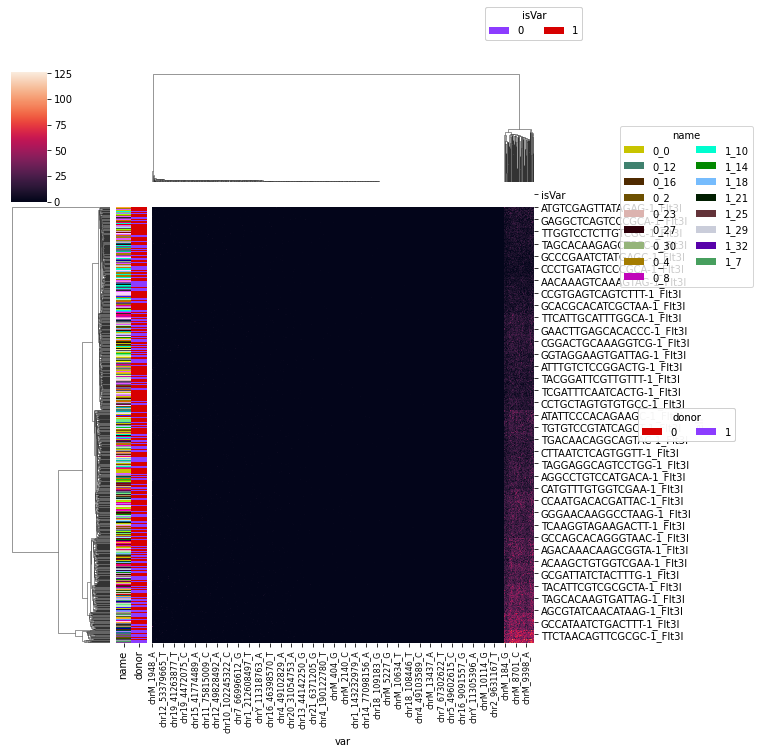

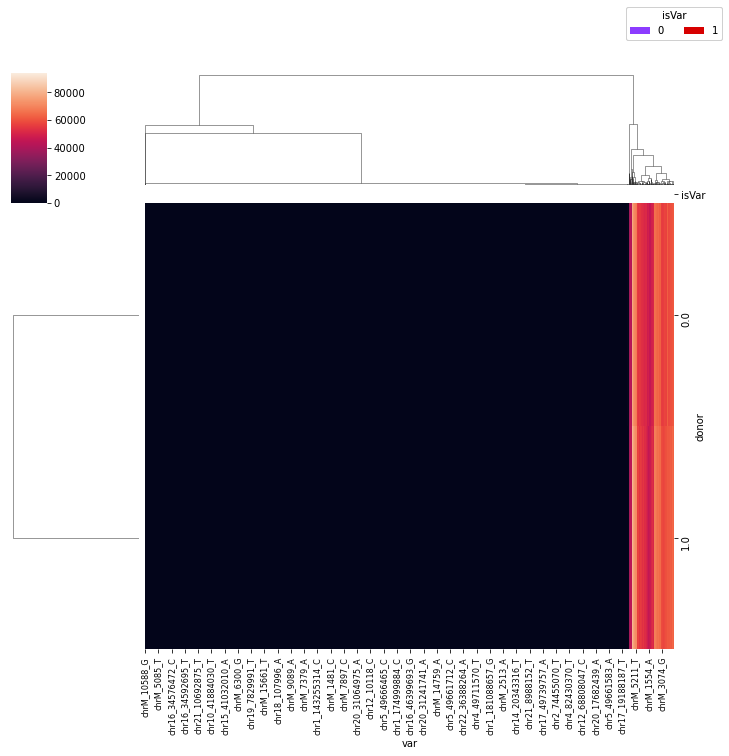

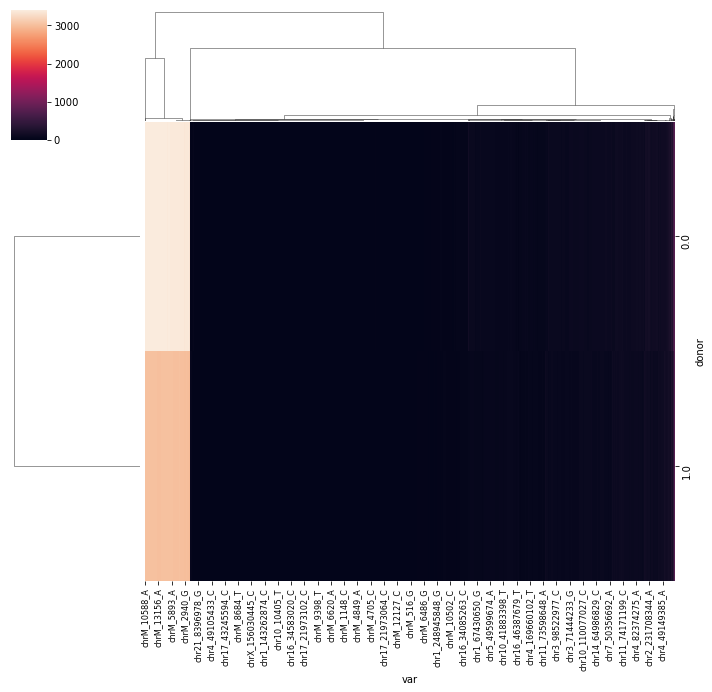

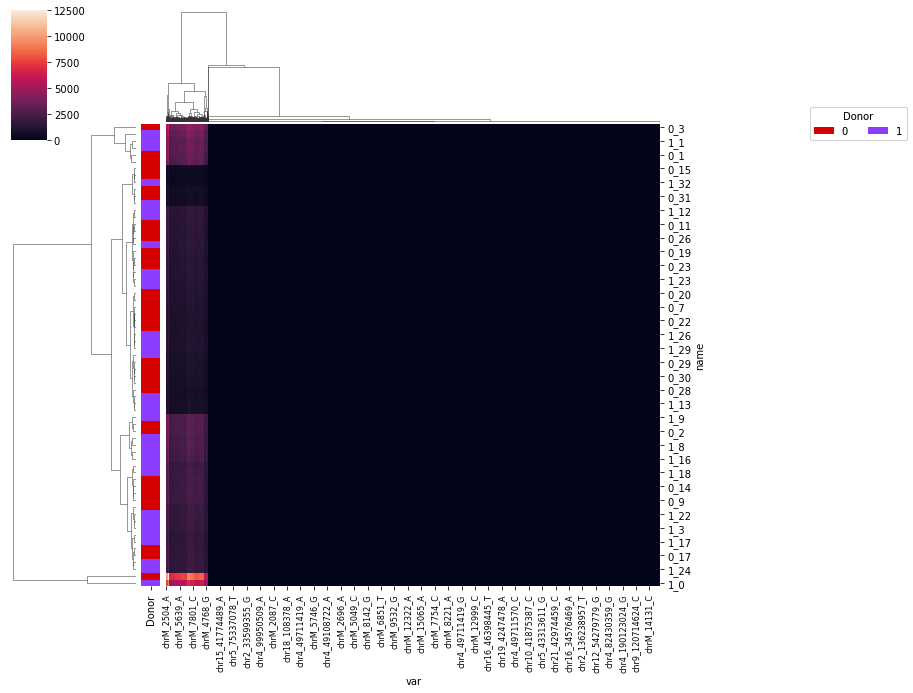

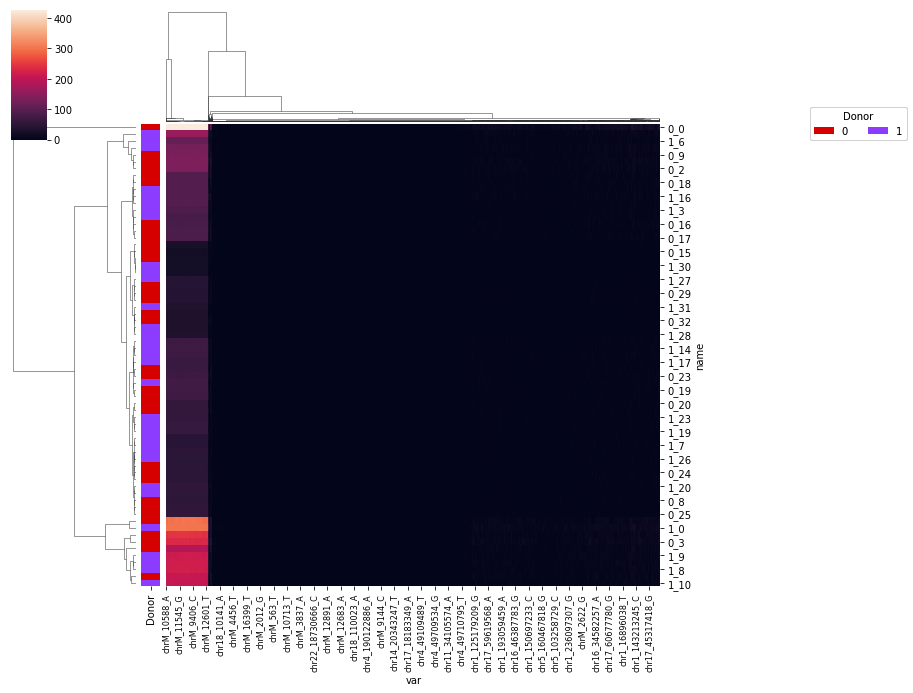

In [8]:
af_mat = af.pivot(index="cell", columns="var", values="count").fillna(0)
if af_mat.shape[0] != 0:
    vars_meta = af_mat.columns
    print("before")
    print('af', af_mat.shape)
    print('cells_meta', cells_meta.shape)
    curr_cells_meta = cells_meta.loc[cells_meta.index.isin(af_mat.index)]
    af_mat = af_mat.loc[af_mat.index.isin(curr_cells_meta.index)]
    print("after")
    print('cells_meta', curr_cells_meta.shape)
    print('af', af_mat.shape)
    #af_mat.shuffle(1000)
    #ch.plot_cluster(af_mat, row_meta=curr_cells_meta[["name", "donor"]], row_clr_schemes = "categorical")
    #plt.savefig(join(outdir, "ad.png"))

    vars_meta = af_mat.columns
    ch.plot_cluster(af_mat.sample(min(af_mat.shape[0],1000)).sample(min(af_mat.shape[1],1000),axis=1), row_meta=curr_cells_meta[["name", "donor"]], col_meta=af[["isVar"]], 
                    col_clr_schemes="categorical", row_clr_schemes = "categorical")
    #plt.savefig(join(outdir, "ad_reference.png"))
    ## Groupby donor and clone and get number of cells > 0

    ## Donors
    donors_df = af.groupby(["donor", "var", "nt"]).sum()["count"].reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="count").fillna(0)

    ch.plot_cluster(donors_mat, col_clr_schemes='categorical', col_meta=af[["isVar"]])
    plt.savefig(join(outdir, "donor_altAndRef_sumCounts.png"))

    ## Number of cells with the variant in donor
    donors_df = af.groupby(["donor", "var", "nt"]).size().to_frame("size").reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="size").fillna(0)
    donors_mat.to_csv(join(outdir, "donor_altAndRef_numCells.csv"))
    ch.plot_cluster(donors_mat)
    plt.savefig(join(outdir, "donor_altAndRef_numCells.png"))


    ## Clones
    clones_df = af.groupby(["name", "var", "nt"]).sum()["count"].reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="count").fillna(0)
    clones_df
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])
    ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.savefig(join(outdir, "clone_altAndRef_sumCounts.png"))

    ## Clone sizes
    clones_df = af.groupby(["name", "var", "nt"]).size().to_frame("size").reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="size").fillna(0)
    clones_mat.to_csv(join(outdir, "clones_altAndRef_numCells.csv"))
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])
    ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.savefig(join(outdir, "clone_altAndRef_numCells.png"))


## isVar, if there are any

before
af (7651, 1327)
curr_cells_meta (6431, 4)
after
curr_cells_meta (6431, 4)
af (6431, 1327)
dat_type {'isVar': 'categorical'}
categorical
dat_type {'name': 'categorical', 'donor': 'categorical'}
categorical
categorical
dat_type {'isVar': 'categorical'}
categorical
dat_type {'Donor': 'categorical'}
categorical
dat_type {'Donor': 'categorical'}
categorical


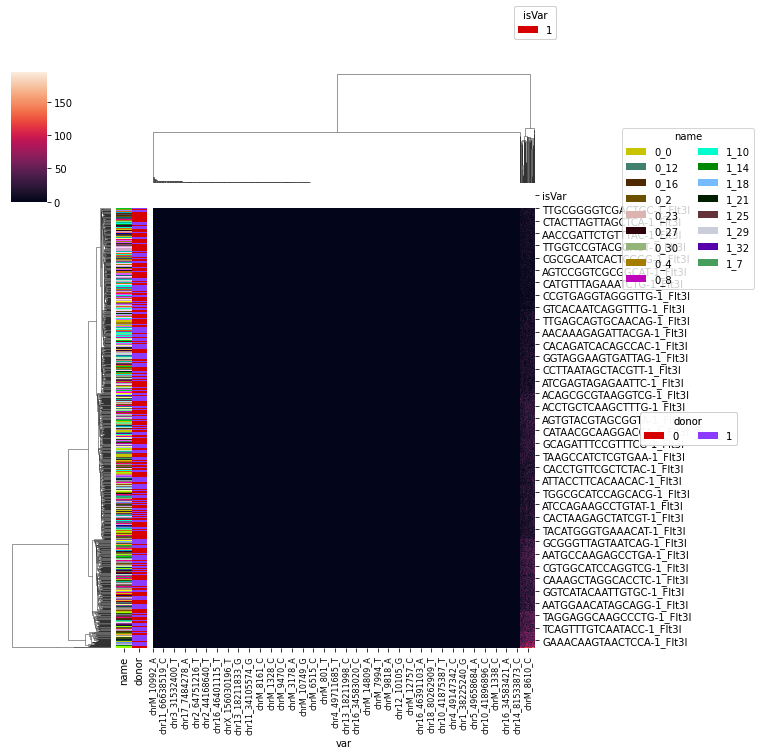

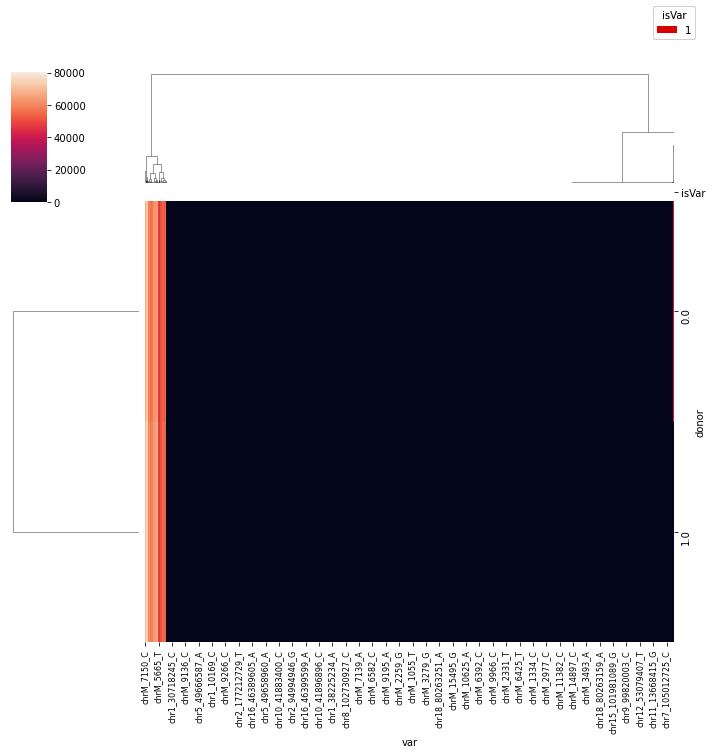

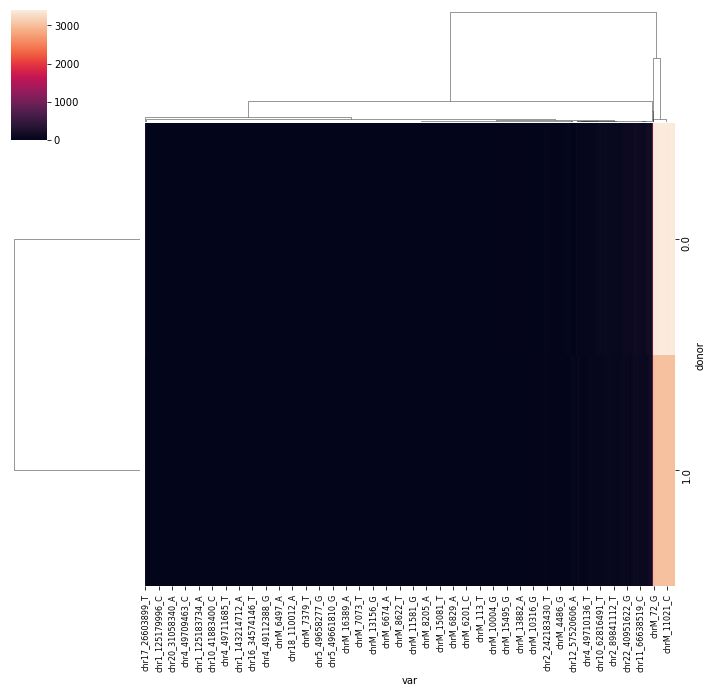

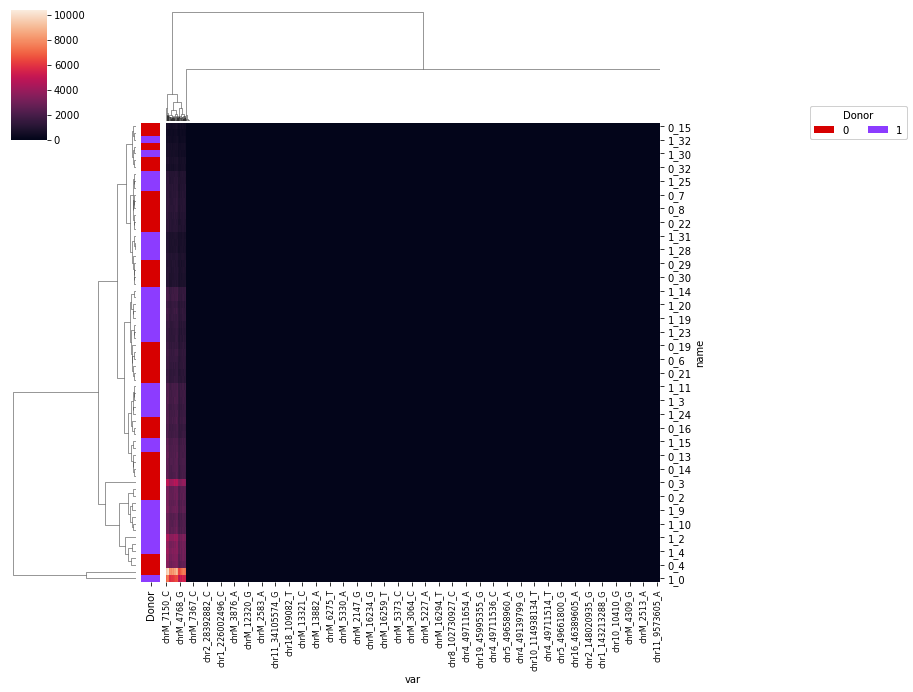

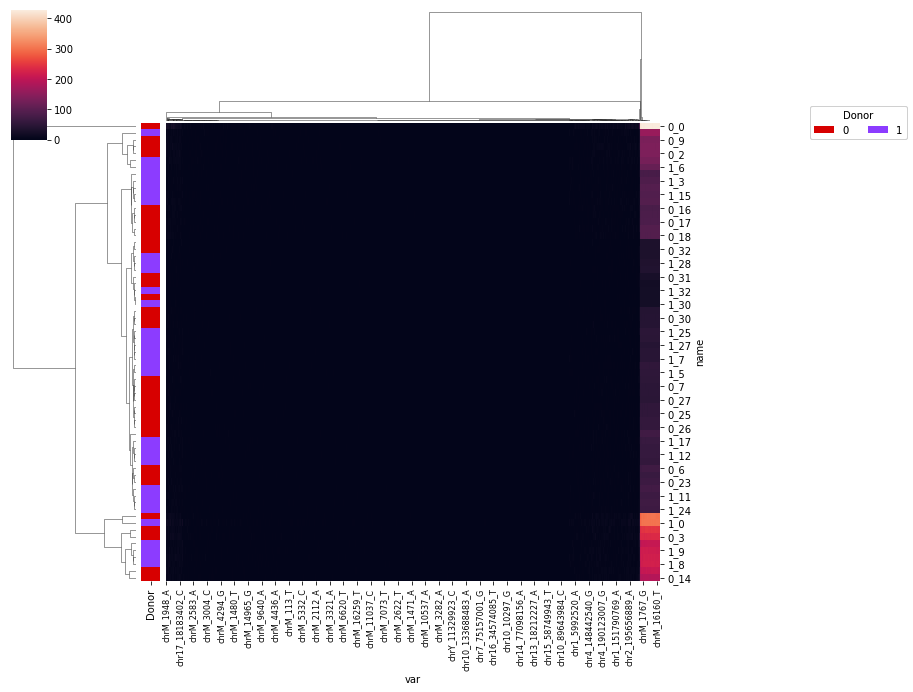

In [10]:
af_isVar = af[af["isVar"]]
af_isVar_mat = af_isVar.pivot(index="cell", columns="var", values="count").fillna(0)

if af_isVar_mat.shape[0] != 0:
    vars_meta = af_isVar_mat.columns
    print("before")
    print('af', af_isVar_mat.shape)
    print('curr_cells_meta', curr_cells_meta.shape)
    curr_cells_meta = cells_meta.loc[cells_meta.index.isin(af_isVar_mat.index)]
    af_isVar_mat = af_isVar_mat.loc[af_isVar_mat.index.isin(curr_cells_meta.index)]
    print("after")
    print('curr_cells_meta', curr_cells_meta.shape)
    print('af', af_isVar_mat.shape)
    
    #ch.plot_cluster(af_isVar_mat, row_meta=curr_cells_meta[["name", "donor"]], row_clr_schemes = "categorical")
    #plt.savefig(join(outdir, "ad.png"))

    vars_meta = af_isVar_mat.columns
    ch.plot_cluster(af_isVar_mat.sample(min(af_isVar_mat.shape[0],1000)).sample(min(af_isVar_mat.shape[1],1000),axis=1), 
                    row_meta=curr_cells_meta[["name", "donor"]], col_meta=af_isVar[["isVar"]], 
                    col_clr_schemes="categorical", row_clr_schemes = "categorical")
    #plt.savefig(join(outdir, "ad_reference.png"))
    ## Groupby donor and clone and get number of cells > 0

    ## Donors
    donors_df = af_isVar.groupby(["donor", "var", "nt"]).sum()["count"].reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="count").fillna(0)
    ch.plot_cluster(donors_mat, col_clr_schemes='categorical', col_meta=af_isVar[["isVar"]])
    plt.savefig(join(outdir, "donor_alt_sumCounts.png"))

    ## Number of cells with the variant in donor
    donors_df = af_isVar.groupby(["donor", "var", "nt"]).size().to_frame("size").reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="size").fillna(0)
    donor_mat.to_csv(join(outdir, "donor_alt_numCells.csv"))
    ch.plot_cluster(donors_mat)
    plt.savefig(join(outdir, "donor_alt_numCells.png"))


    ## Clones
    clones_df = af_isVar.groupby(["name", "var", "nt"]).sum()["count"].reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="count").fillna(0)
    clones_df
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])

    ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.savefig(join(outdir, "clone_alt_sumCounts.png"))

    ## Clone sizes
    clones_df = af_isVar.groupby(["name", "var", "nt"]).size().to_frame("size").reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="size").fillna(0)
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])
    clones_mat.to_csv(join(outdir, "clones_alt_numCells.csv"))
    ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.savefig(join(outdir, "clone_alt_numCells.png"))